In [1]:
#Imports
import cProfile
import random
import math
import geohash
import geotools
import networkx as nx
import numpy as np
from scipy import spatial,stats
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Geographic Sims</h2>

In [2]:
def generate_nodes(N,pop_min_max,lat_min_max,lon_min_max):
    '''Generate a normally random dictionary of N geographic nodes with data dictionary of node population and lat/lon coords
    N = numer of nodes
    pop_min_max = tuple of [min,max] population thresholds
    lat_min_max = tuple of [min,max] latitude thresholds
    lon_min_max = tuple of [min,max] longitude thresholds
    '''
    
    node_dict = {}
    for node in range(N):
        lat = random.uniform(*lat_min_max)
        lon = random.uniform(*lon_min_max)
        gh = geohash.encode(lat,lon)
        node_dict[gh] = {'pop':random.randint(*pop_min_max),
                           'lat':lat,
                           'lon':lon,
                           'geohash':gh
                          }
    return node_dict

def generate_network(node_dict,max_connect_dist,link_prob):
    seen_edges = []
    G = nx.Graph()
    for node,data in node_dict.items():
        if node not in G.nodes():
            G.add_node(node,attr_dict=data)
        possible_connections = geotools.get_close_ghs(data['geohash'],G.nodes(),max_connect_dist)
        for connection_node in possible_connections:
            edge_hash = ''.join(sorted([node,connection_node]))
            if random.random() <= link_prob and edge_hash not in seen_edges:
                G.add_edge(node,connection_node)
            seen_edges.append(edge_hash)
    return G

In [85]:
node_dict = generate_nodes(10,[10,100],[30.,70],[40,50])
G = generate_network(node_dict,0.1,0.1)

tj89vxxhz4ggtj89vxxhz4gg


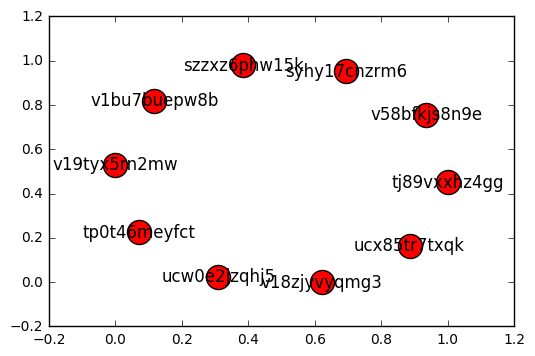

In [86]:
nx.draw_networkx(G)

<h2>Distance Weighted Geographical Threshold Graphs Sims</h2>

In [5]:
def link_prob_vs_distance(distance,max_distance,funct='unit',funct_params=[]):
    if funct == 'unit':
        if distance <= max_distance:
            return 1
        else:
            return 0
    elif funct == 'linear':
        return 1-funct_params[0]*distance/max_distance
    elif funct == 'exponential':
        return funct_params[0]*math.exp(-funct_params[1]*distance/max_distance)
    elif funct == 'normal':
        return stats.norm.pdf(distance/max_distance,loc=funct_params[0],scale=funct_params[1])

def generate_graph_nodes(N,dimensions=2):
    G = nx.Graph()
    for node in range(N):
        pos = [random.random() for dim in range(dimensions)]
        G.add_node(node,pos=pos,weight=random.random())
    return G

def distance_weighted_GTG(G,max_distance,threshold,funct = 'unit',funct_params=[]):
    pos_points = list(nx.get_node_attributes(G, 'pos').values())
    point_tree = spatial.cKDTree(pos_points)
    potential_edges = point_tree.query_pairs(max_distance, len(pos_points[0]))
    for edge in potential_edges:
        dist = spatial.distance.euclidean(G.node[edge[0]]['pos'],G.node[edge[1]]['pos'])
        link_prob = link_prob_vs_distance(dist,max_distance,funct,funct_params)
        link_strength = (G.node[edge[0]]['weight']+G.node[edge[0]]['weight'])*link_prob
        if link_strength >= threshold:
            G.add_edge(edge[0],edge[1],weight=link_strength)
    return G

def visualize_GTG(GTG):
    """
    Filename: nx_demo.py
    Authors: John Stachurski and Thomas J. Sargent
    """
    pos = nx.get_node_attributes(GTG, 'pos')    # Get positions of nodes
    plt.figure(figsize=(8,8))
    nx.draw_networkx_edges(GTG, pos, alpha=0.4)
    nx.draw_networkx_nodes(GTG, pos, nodelist=list(GTG.nodes()),
                           node_size=120, alpha=0.5,node_color='blue')
    plt.show()

In [6]:
G=generate_graph_nodes(200)

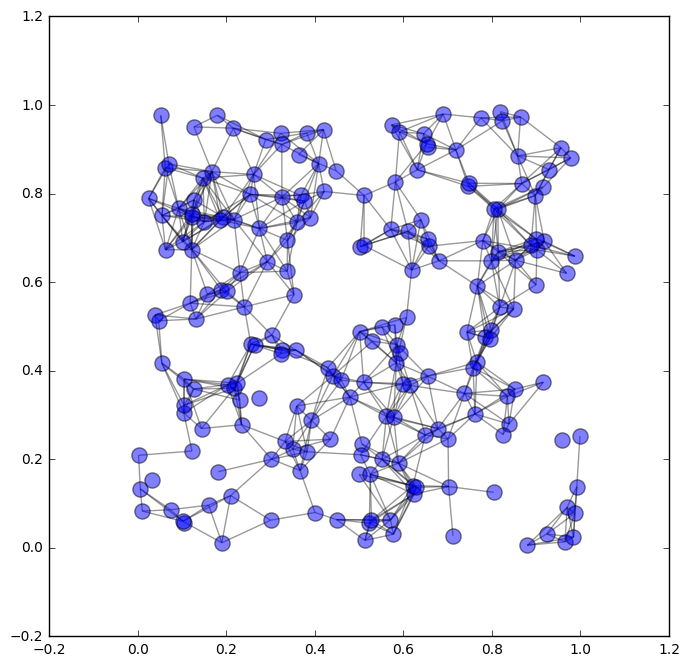

In [7]:
GTG = distance_weighted_GTG(G.copy(),0.125,0.5,funct='unit')
visualize_GTG(GTG)

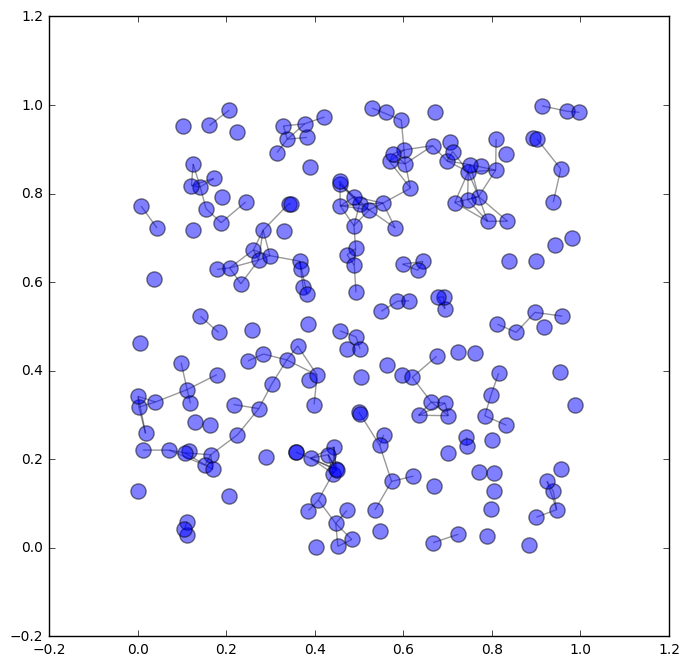

In [29]:
GTG = distance_weighted_GTG(G.copy(),0.125,0.5,funct='linear',funct_params=[1])
visualize_GTG(GTG)

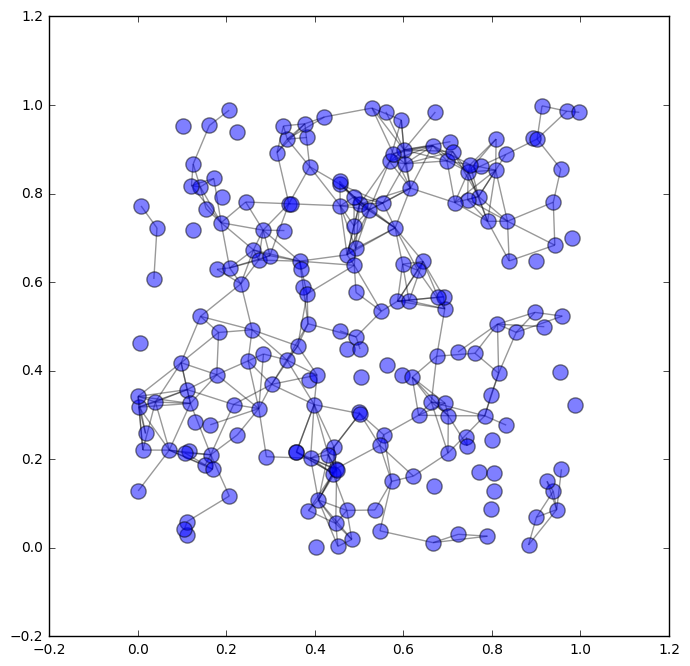

In [30]:
GTG = distance_weighted_GTG(G.copy(),0.125,0.5,funct='exponential',funct_params=[1,1])
visualize_GTG(GTG)

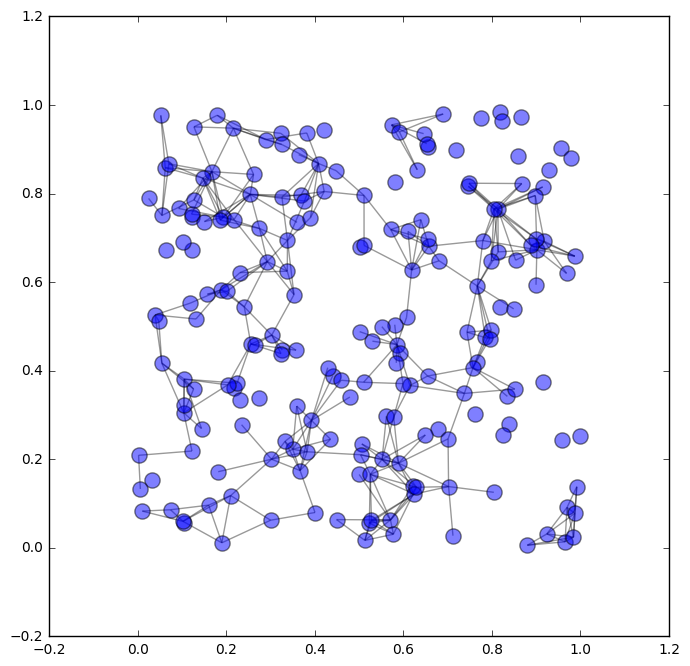

In [32]:
GTG = distance_weighted_GTG(G.copy(),0.125,0.5,funct='normal',funct_params=[0.5,1])
visualize_GTG(GTG)

In [30]:
def coverage(G,radius,resolution=100):
    biggest_comp = max(nx.connected_component_subgraphs(G), key=len)
    half_length = math.floor(radius/(math.sqrt(2)*2))
    grid = np.zeros([resolution,resolution])
    for node,data in biggest_comp.nodes_iter(data=True):
        top_left = [math.floor(data['pos'][0]*resolution)-half_length,math.floor(data['pos'][1]*resolution)-half_length]
        for x in range(half_length*2):
            for y in range(half_length*2):
                if top_left[0]+x <= resolution-1 and top_left[1] + y <=resolution-1:
                    grid[top_left[0]+x,top_left[1] + y] = 1
    return np.count_nonzero(grid)/resolution**2

In [33]:
coverage(GTG,20)

0.8844

In [ ]:
def network_profiling(G):
    for i in range(len(G)):
        biggest_comp = max(nx.connected_component_subgraphs(G), key=len)

In [63]:
def profile_GTG(N):
    G=generate_graph_nodes(N)
    return distance_weighted_GTG(G,0.125,0.2,funct='unit')